In [377]:
import numpy as np
from numpy import *
from numpy.random import *
import time
import mdp
import matplotlib.pyplot as plt
import seaborn as sns

**The Izhikevich Model**

(1) dv/dt = 0.04v^2 + 5v + 140 - u + I\
(2) du/dt = a(bv-u)\
(3) if v = 30mV, then: v <- c; u <- u+d

**where:**\
v = membrane potential \
u = recovery variable \
a = time scale of recovery \
b = sensitivity of recovery to subthreshold oscillations \
c = after-spike reset value of v \
d = after-spike reset increment of u 

In [372]:
def timeStep(a,b,c,d,v,u,i,thresh=30,substeps=2):
    """ worker function for simulation. given parameters and current state variables, compute next ms """
    
    fired = v>thresh     # array of indices of spikes
    print('fired', sum(fired))
    v1 = v             # next step of membrane potential v
    u1 = u             # next step of recovery variable u
    #spikesum = sum(fired), sum(fired[:Ne]), sum(fired[Ne:])
    
    ### Action potentials ###
    v[fired] = thresh
    v1[fired] = c[fired]                # reset the voltage of any neuron that fired to c
    u1[fired] = u[fired] + d[fired]     # reset the recovery variable of any neuron that fired to u_0 + d
    i1 = i + sum(S[:,fired],axis=1)    # sum spontanous thalamic input and weighted inputs from all other neurons
    
    ### Step forward ###
    for i in range(substeps):  # for numerical stability, execute at least two substeps per ms
        v1 += (1.0/substeps)*(0.04*(v1**2)+(5*v1)+140-u+i1) # 
        u1 += (1.0/substeps)*a*(b*v1-u1)
    return v1, u1, i1, fired

def simulate(a,b,c,d,v0,u0,length,verbose=True):
    global It, I, Itrace
    """ input:
    - for each of N neurons: parameters a,b,c,d, initial voltage v0 and recovery variables u0
    - length of simulation in milliseconds
    - NxN synaptic weight matrix
    
    processing:
        - simulates network evolution with spike-timing-dependent plasticity
    
    output:
        - Nxlength matrix of membrane voltages v over time
        - Nxlength matrix of recovery variables u over time
        - Nxlength matrix of synaptic inputs i over time
    """
    vout = np.zeros((N,length),dtype=double)
    vout[:,0] = v                                          # initial voltages
    uout = np.zeros((N,length),dtype=double)
    uout[:,0] = u
    iout = np.zeros((N,length),dtype=double)               # synaptic input matrix
    iout[:,0] = np.concatenate((5*rand(Ne),2*rand(Ni)))  # random thalamic input
    
    t0 = time.clock()
    
    ## simulate
    for t in range(1,length):
        AI = np.concatenate((rand(Ne), rand(Ni))) # thalamic input
        AI = AI > 0.7
        It += AI
        It = It - It*decay
        Itrace[t,:] = It
        
        vout[:,t],uout[:,t],iout[:,t],firings[t][1] = timeStep(a,b,c,d,vout[:,t-1],uout[:,t-1],It)
        firings[t][0] = t
        #I = It+sum(S[:,firings[t][1]],2)
        
        # report progress
        if verbose and t % 100 == 0:
            print("Simulated " + str(t) + "ms of braintime in " + str(time.clock()-t0) + "s of computer time.") 
    
    t1 = time.clock()
    print("Simulation took " + str((t1-t0)) + "s")
    return vout,uout,iout

In [373]:
length = 1000    # simulation time in ms
Ne = 800         # number of excitatory neurons
Ni = 200        # number of inhibitory neurons
N = Ne+Ni        # total number of neurons
print(N, 'neurons in total')
S = np.concatenate((0.5*rand(N,Ne), -0.9*rand(N,Ni)),axis=1)  #initial synaptic weights
firings = np.zeros((length,2,N))
re = np.array(rand(Ne),dtype=double)  # uniformly distributed random doubles [0,1)
ri = np.array(rand(Ni),dtype=double)  # uniformly distributed random doubles [0,1)
    
a = np.concatenate((0.02+0.001*re,0.02+0.02*ri))     # a = time scale of recovery
b = np.concatenate((0.2+0.001*re, 0.25-0.05*ri))     # b = sensitivity of recovery to subthreshold oscillations
c = np.concatenate((-65+5*(re**2),-65+0.5*(ri**2)))  # c = after-spike reset value of v
d = np.concatenate((8-6*(re**2),  2+0.5*(ri**2)))    # d = after-spike reset increment of u
v = -65.0 * np.ones(N,dtype=double) # Initial values of v
u = b*v    # Initial values of u
    
I = (5*np.random.normal(size=(Ne)), 2*np.random.normal(size=(Ni))) # thalamic input
I = np.concatenate(I)
It = I*0
Itrace  = np.zeros(shape=(length, N))
decay = 0.1

vo, uo, io = simulate(a,b,c,d,v,u,length,verbose=True)

1000 neurons in total
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 4
fired 6
fired 6
fired 3
fired 1
fired 4
fired 3
fired 1
fired 1
fired 1
fired 2
fired 2
fired 1
fired 3
fired 3
fired 3
fired 6
fired 3
fired 2
fired 7
fired 6
fired 1
fired 1
fired 2
fired 1
fired 1
fired 2
fired 3
fired 5
fired 7
fired 11
fired 5
fired 4
fired 11
fired 3
fired 9
fired 2
fired 4
fired 3
fired 9
fired 11
fired 14
fired 13
fired 18
fired 31
fired 22
fired 23
fired 17
fired 18
fired 17
fired 19
fired 30
fired 53
fired 62
fired 123
fired 214
fired 292
fired 352
fired 489
fired 351
fired 649
fired 488
fired 512
fired 341
fired 659
fired 1000
fired 525
fired 475
fired 337
fired 663
fired 1000
fired 339
fired 278
fired 104
fired 28
fired 181
fired 31
fired 4
fired 0
fired 1
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
Simulated 100ms of braintime in 0.13612300000386313s of computer time.
fired 0
fired 0
fired 0
fired 0
fired 0
fired

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 0
fired 1
fired 0
fired 0
fired 0
fired 1
fired 0
fired 2
fired 3
fired 1
fired 1
fired 0
fired 1
fired 1
fired 1
fired 1
fired 0
fired 0
fired 0
fired 1
fired 5
fired 1
fired 3
fired 1
fired 1
fired 1
fired 1
fired 3
fired 0
fired 3
fired 3
fired 1
fired 0
fired 3
fired 3
fired 3
fired 3
fired 0
fired 1
fired 3
fired 3
fired 2
fired 0
fired 3
fired 1
Simulated 200ms of braintime in 0.22005080000235466s of computer time.
fired 3
fired 3
fired 3
fired 4
fired 1
fired 1
fired 1
fired 1
fired 2
fired 5
fired 3
fired 2
fired 5
fired 3
fired 0
fired 3
fired 1
fired 0
fired 2
fired 1
fired 0
fired 3
fired 2
fired 4
fired 4
fired 6
fired 2
fired 0
fired 2
fired 2
fired 2
fired 2
fired 2
fired 1
fired 0
fired 1
fired 2
fired 3
fired 2
fired 1
fired 4
fired 6
fired 2
fired 2
fired 5
fired 2
fired 3
fired 0
fired 1
fired 1
fired 2
fired 0
fired 2
f

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [374]:
vo1 = vo.copy()
vo1[vo1 > 30] = 30

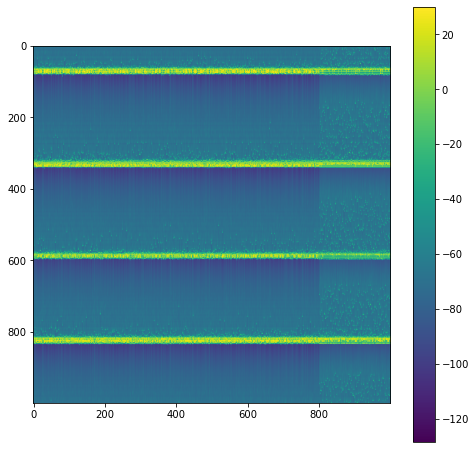

In [375]:
h, w = vo1.shape #firings[:,1]

fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(vo1.T) #firings[:,1]
plt.colorbar()

ax.set_aspect(w/h)
plt.show()